In [30]:
import kagglehub
import os
# Download latest version
path = os.path.join(os.getcwd(),"data") 
path = kagglehub.dataset_download("andrewmvd/drive-digital-retinal-images-for-vessel-extraction",output_dir= path)

print("Path to dataset files:", path)

Path to dataset files: c:\Github\assignment-3\data


In [31]:
# Import necessary libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import random
from skimage.filters import threshold_niblack, threshold_sauvola
from torchvision import transforms

In [32]:
# Image Transform Pipeline using torchvision.transforms
class BGRtoGrayscaleNormalize:
    """Convert BGR to Grayscale and Normalize to [0, 1]"""
    def __call__(self, image):
        # Convert BGR to RGB first, then to Grayscale
        rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
        # Normalize to [0, 1]
        gray = gray.astype(np.float32) / 255.0
        return gray

# Create transform pipeline
transform = transforms.Compose([
    BGRtoGrayscaleNormalize()
])


# DataLoader for DRIVE Dataset
class DRIVEDataLoader:
    """
    DRIVE Dataset Loader - loads retinal images and vessel segmentations
    
    Returns:
    - 'image': Preprocessed grayscale image (normalized to [0, 1])
    - 'vessels': Vessel segmentation masked by FOV (binary)
    - 'name': Image identifier
    """
    def __init__(self, data_dir: str, split: str = 'training', transforms=None):
        self.split_dir = Path(data_dir) / 'DRIVE' / split
        self.image_dir = self.split_dir / 'images'
        self.mask_dir = self.split_dir / 'mask'
        self.split = split
        self.transforms = transforms
        
        # Vessel directory only for training
        if split == 'training':
            self.vessel_dir = self.split_dir / '1st_manual'
        else:
            self.vessel_dir = None
        
        # Get image names
        self.image_names = sorted([f.stem for f in self.image_dir.glob('*.tif')])
        print(f"Loaded {len(self.image_names)} images from {split} set")
    
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, idx):
        name = self.image_names[idx]
        
        # Load image
        img_path = self.image_dir / f"{name}.tif"
        image = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
        
        # Apply transforms
        if self.transforms:
            image = self.transforms(image)
        
        # Load FOV mask
        mask_path = self.mask_dir / f"{name}_mask.gif"
        fov_mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
        fov_mask = (fov_mask > 0).astype(np.uint8)
        
        # Load and mask vessels
        if self.vessel_dir:
            img_number = name.split('_')[0]
            vessel_path = self.vessel_dir / f"{img_number}_manual1.gif"
            vessels = cv2.imread(str(vessel_path), cv2.IMREAD_GRAYSCALE)
            vessels = (vessels > 0).astype(np.uint8)
            vessels = vessels * fov_mask  # Apply FOV mask
        else:
            vessels = None
        
        return {
            'image': image,
            'vessels': vessels,
            'name': name
        }


# Initialize dataloaders
data_path = os.path.join(os.getcwd(), "data")
train_loader = DRIVEDataLoader(data_path, split='training', transforms=transform)
test_loader = DRIVEDataLoader(data_path, split='test', transforms=transform)

Loaded 20 images from training set
Loaded 20 images from test set


In [33]:
# Segmentation Methods: Niblack vs Sauvola

def apply_niblack(image: np.ndarray, window_size: int = 25, k: float = 0.2) -> np.ndarray:
    """Niblack Local Thresholding - works on grayscale"""
    # Ensure image is in range [0, 255]
    if image.max() <= 1.0:
        image = (image * 255).astype(np.uint8)
    else:
        image = image.astype(np.uint8)
    
    # Apply Niblack thresholding
    threshold = threshold_niblack(image, window_size=window_size, k=k)
    binary = (image > threshold).astype(np.uint8) * 255
    return binary

def apply_sauvola(image: np.ndarray, window_size: int = 25, k: float = 0.2) -> np.ndarray:
    """Sauvola Local Thresholding - works on grayscale"""
    # Ensure image is in range [0, 255]
    if image.max() <= 1.0:
        image = (image * 255).astype(np.uint8)
    else:
        image = image.astype(np.uint8)
    
    # Apply Sauvola thresholding
    threshold = threshold_sauvola(image, window_size=window_size, k=k)
    binary = (image > threshold).astype(np.uint8) * 255
    return binary

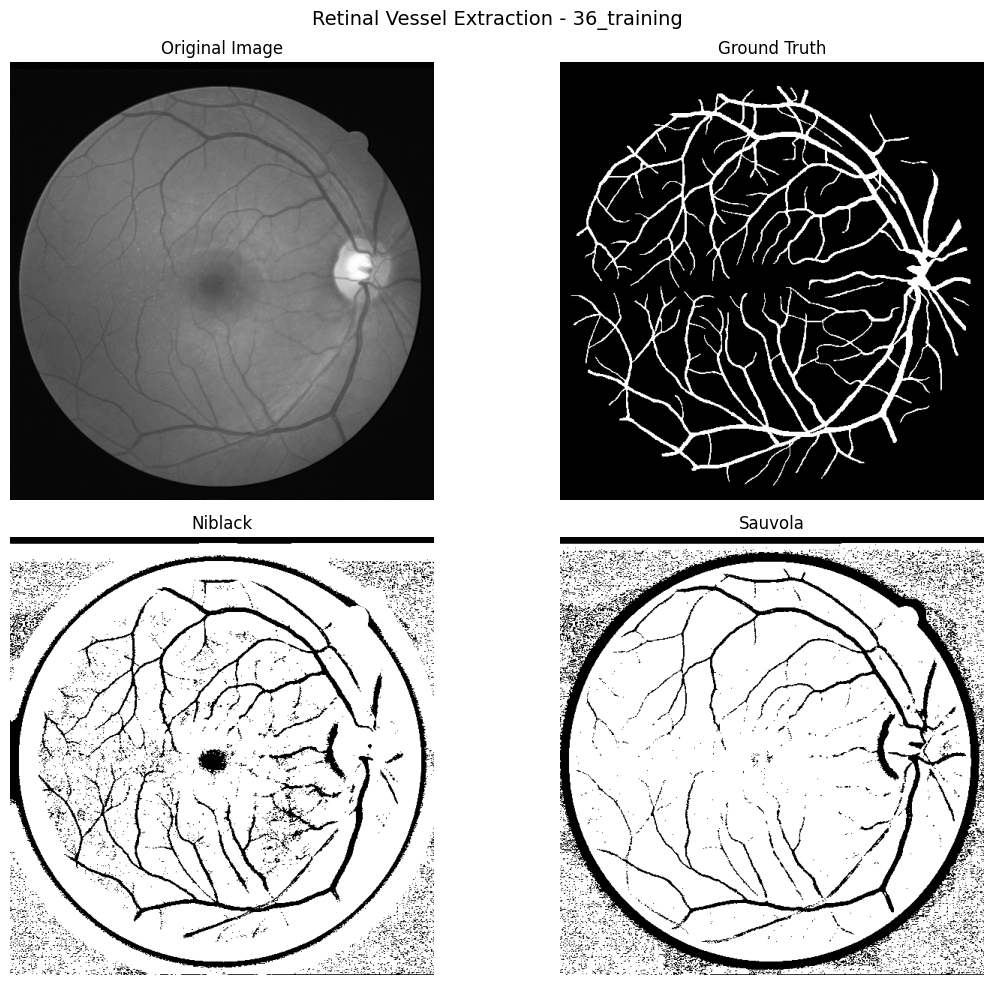

In [34]:
# Visualization: Random Image with Both Methods

sample_idx = random.randint(0, len(train_loader) - 1)
sample = train_loader[sample_idx]

image = sample['image']
vessels_gt = sample['vessels']
image_name = sample['name']

niblack_result = apply_niblack(image, window_size=51, k=0.7)
sauvola_result = apply_sauvola(image, window_size=23, k=0.08)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle(f'Retinal Vessel Extraction - {image_name}', fontsize=14)

axes[0, 0].imshow(image, cmap='gray')
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')

axes[0, 1].imshow(vessels_gt, cmap='gray')
axes[0, 1].set_title('Ground Truth')
axes[0, 1].axis('off')

axes[1, 0].imshow(niblack_result, cmap='gray')
axes[1, 0].set_title('Niblack')
axes[1, 0].axis('off')

axes[1, 1].imshow(sauvola_result, cmap='gray')
axes[1, 1].set_title('Sauvola')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

In [35]:
def sensitivity(pred: np.ndarray, gt: np.ndarray) -> float:
    p_bin = (pred > 0).astype(np.uint8)
    g_bin = (gt > 0).astype(np.uint8)
    tp = np.sum((p_bin == 1) & (g_bin == 1))
    fn = np.sum((p_bin == 0) & (g_bin == 1))
    return tp / (tp + fn) if (tp + fn) > 0 else 0.0

def dice_coefficient(pred: np.ndarray, gt: np.ndarray) -> float:
    p_bin = (pred > 0).astype(np.uint8)
    g_bin = (gt > 0).astype(np.uint8)
    intersection = np.sum((p_bin == 1) & (g_bin == 1))
    return 2 * intersection / (np.sum(p_bin) + np.sum(g_bin)) if (np.sum(p_bin) + np.sum(g_bin)) > 0 else 0.0

def jaccard_index(pred: np.ndarray, gt: np.ndarray) -> float:
    p_bin = (pred > 0).astype(np.uint8)
    g_bin = (gt > 0).astype(np.uint8)
    intersection = np.sum((p_bin == 1) & (g_bin == 1))
    union = np.sum((p_bin == 1) | (g_bin == 1))
    return intersection / union if union > 0 else 0.0

# Compare metrics for both methods
print("\nNiblack Method:")
niblack_sens = sensitivity(niblack_result, vessels_gt)
niblack_jaccard = jaccard_index(niblack_result, vessels_gt)
niblack_dice = dice_coefficient(niblack_result, vessels_gt)

print(f"  Sensitivity: {niblack_sens:.4f}")
print(f"  Jaccard: {niblack_jaccard:.4f}")
print(f"  Dice: {niblack_dice:.4f}")

print("\nSauvola Method:")
sauvola_sens = sensitivity(sauvola_result, vessels_gt)
sauvola_jaccard = jaccard_index(sauvola_result, vessels_gt)
sauvola_dice = dice_coefficient(sauvola_result, vessels_gt)

print(f"  Sensitivity: {sauvola_sens:.4f}")
print(f"  Jaccard: {sauvola_jaccard:.4f}")
print(f"  Dice: {sauvola_dice:.4f}")


Niblack Method:
  Sensitivity: 0.5032
  Jaccard: 0.0603
  Dice: 0.1137

Sauvola Method:
  Sensitivity: 0.5715
  Jaccard: 0.0714
  Dice: 0.1332
